[View in Colaboratory](https://colab.research.google.com/github/GianCiccarelli/GIAN-Notebook/blob/master/GAN_Traditional.ipynb)

In [0]:
# https://github.com/eriklindernoren/Keras-GAN#gan

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1X8lO_DfwWA8cSvLxhDZ2r_Hx1263EZXm'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('triplets.zip')

!unzip triplets.zip
!ls
!mkdir 'images/'

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend

import matplotlib.pyplot as plt

import sys, os

import numpy as np

import psutil
import gc

from PIL import Image

!pip install numba
from numba import cuda

Using TensorFlow backend.


In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 316 // 2
        self.img_cols = 760 // 2
        self.channels = 3
        self.img_shape_in = (2, self.img_rows, self.img_cols, self.channels)
        self.img_shape_out = (self.img_rows, self.img_cols, self.channels)
        #self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes a set of 2 frames stacked on top of eachother
        z = Input(shape=self.img_shape_in)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape_in))
        model.add(Dense(256))#, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape_out), activation='tanh'))
        model.add(Reshape(self.img_shape_out))

        model.summary()

        img_duo = Input(shape=self.img_shape_in)
        img = model(img_duo)

        return Model(img_duo, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape_out))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape_out)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=16, sample_interval=50):

        # Load the dataset
        (X_train, y_train) = self.load_triplets()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        y_train = y_train / 127.5 - 1.
        
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            imgs_out = y_train[idx]
            
            gen_imgs = self.generator.predict(imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs_out, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(imgs, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch, imgs)

    def sample_images(self, epoch, imgs):
       
        gen_imgs = self.generator.predict(imgs)
        
        dir_epoch = "images/{}/".format(epoch)

        # Rescale images 0 - 1
        #gen_imgs = 0.5 * gen_imgs + 0.5
        
        if not os.path.isdir(dir_epoch):
            os.mkdir(dir_epoch)

        for i in range(gen_imgs.shape[0]):
            result = Image.fromarray(((gen_imgs[i] + 1) * 127.5).astype(np.uint8))
            result.save(dir_epoch + '{}.png'.format(i))
            
        del gen_imgs
        
    def load_triplets(self):
        triplets_dir = 'triplets/'
        
        X_train = []
        y_train = []
        
        fnames = ['{}-triplet.png'.format(str(i).zfill(3)) for i in range(1, 37)]
        for fname in fnames:
            img = np.array(Image.open(os.path.join(triplets_dir, fname)).resize((self.img_cols, self.img_rows * 2)))
            X_train.append([img[self.img_rows:], img[:self.img_rows]])
            
        fnames = ['{}-groundtruth.png'.format(str(i).zfill(3)) for i in range(1, 37)]
        for fname in fnames:
            img = np.array(Image.open(os.path.join(triplets_dir, fname)).resize((self.img_cols, self.img_rows)))
            y_train.append(img)
            
        X_train = np.array(X_train, dtype=np.float64)
        y_train = np.array(y_train, dtype=np.float64)
            
        return X_train, y_train
            
    def __del__(self):
        print("Delet")
        keras.backend.clear_session()
        del self.generator
        del self.discriminator
        del self.combined
        


In [0]:
!ls images

In [3]:
gan = GAN()
gan.train(epochs=5000, batch_size=4, sample_interval=250)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 180120)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               92221952  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 92,353,537
Trainable params: 92,353,537
Non-trainable params: 0
________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.444504, acc.: 100.00%] [G loss: 0.776805]
1 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.560935]
2 [D loss: 0.200483, acc.: 87.50%] [G loss: 7.791678]
3 [D loss: 0.000000, acc.: 100.00%] [G loss: 8.059048]
4 [D loss: 0.000000, acc.: 100.00%] [G loss: 8.059048]
5 [D loss: 0.000000, acc.: 100.00%] [G loss: 10.760568]
6 [D loss: 7.971192, acc.: 50.00%] [G loss: 8.059048]
7 [D loss: 7.971192, acc.: 50.00%] [G loss: 8.341185]
8 [D loss: 0.000000, acc.: 100.00%] [G loss: 7.770537]
9 [D loss: 0.000000, acc.: 100.00%] [G loss: 4.163962]
10 [D loss: 0.000000, acc.: 100.00%] [G loss: 8.059048]
11 [D loss: 0.000000, acc.: 100.00%] [G loss: 6.565692]
12 [D loss: 0.000000, acc.: 100.00%] [G loss: 8.059048]
13 [D loss: 0.000000, acc.: 100.00%] [G loss: 8.059048]
14 [D loss: 0.000000, acc.: 100.00%] [G loss: 8.059048]
15 [D loss: 0.000000, acc.: 100.00%] [G loss: 8.059048]
16 [D loss: 0.000000, acc.: 100.00%] [G loss: 4.044737]
17 [D loss: 0.000000, acc.: 100.00%] [G loss: 4.029524]
18 [

KeyboardInterrupt: ignored

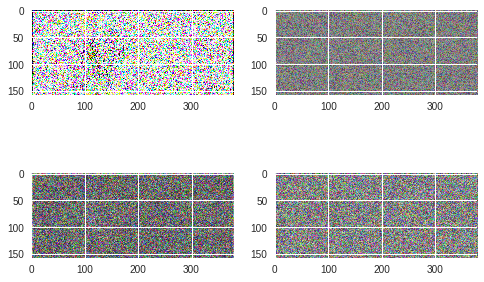

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

epoch = 3000

_, axs = plt.subplots(nrows=2, ncols=2)

axs = axs.flatten()

for (index, ax) in zip(range(4), axs):
  img = mpimg.imread('images/{}/{}.png'.format(epoch, index))
  ax.imshow(img)

In [0]:
(X_train, y_train) = gan.load_triplets()

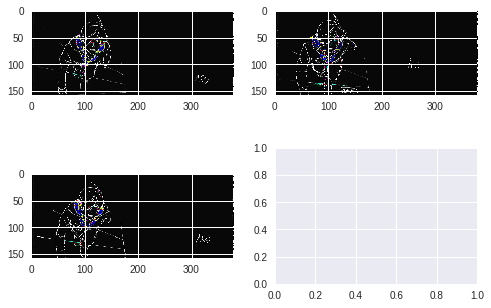

In [8]:
_, axs = plt.subplots(nrows=2, ncols=2)

axs = axs.flatten()
triplet_num = 0

for (index, ax) in zip(range(2), axs):
  img = X_train[triplet_num][index]
  ax.imshow(img)
axs[2].imshow(y_train[triplet_num])

In [15]:
psutil.Process().memory_info().rss / 2**20 # In MB

3415.17578125

In [10]:
keras.backend.clear_session()
gc.collect()

16247

In [12]:
del gan
gc.collect()

Delet


172940

In [0]:

cuda.select_device(0)
cuda.close()
